In [1]:
%matplotlib notebook

import tensorflow as tf
from tensorflow.keras import backend as K

import tensorflow_probability as tfp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

import seaborn as sns
from scipy import stats
import os
from sklearn.metrics import r2_score, mean_absolute_error
from joblib import load

import sys
sys.path.insert(0,'..')
from models import get_model3


mpl.rc('font', **{'family':'sans-serif', 'sans-serif':['DejaVu Sans']})
mpl.rc('text', usetex = True)


K.clear_session()
sns.set()

tf.__version__

'2.8.0'

## Import and preprocess data

* Note the z-score method is used for removing outliers with a threshold of 3
* A number of redundant features are drop


In [2]:
w1 = pd.read_csv('../data/well1.csv')
w2 = pd.read_csv('../data/well2.csv')

def _remove_outlier_z(data, th=3):
    
    s1 = data.shape
    z_score = np.abs(stats.zscore(data))
    idx = np.where(z_score>th)
    data = data.drop(idx[0], axis=0)
    data = data[data>0].dropna()
    data = data.reset_index().drop(['index'], axis=1)
    data = data.sort_values(by=['Hole Depth'], ascending=True)
    s2 = data.shape
    print(f'Shape before removing outliser {s1} \t\t shape after removing the outliers {s2}')
    
    return data        

w1 = _remove_outlier_z(w1, th=3)
w2 = _remove_outlier_z(w2, th=3)

Shape before removing outliser (7999, 21) 		 shape after removing the outliers (7437, 21)
Shape before removing outliser (9091, 21) 		 shape after removing the outliers (8154, 21)


In [3]:
drop = ['Standpipe Pressure', 'Bit Depth', 'Bit RPM', 'Min RPM', 'Min Hook Load', 'Min Pressure', 
       'Line Wear', 'Block Height', 'Time Of Penetration', 'Min WOB']

w1 = w1.drop(drop, axis=1)
w2 = w2.drop(drop, axis=1)

### Load model and create input data
* Note the scaler object was fitted on the original training data and should be used for correct transformation of the data
* The model must be built and compiled and then weights can be loaded
* Inference requires the number of times to run the model be set (default to 50), set n to higher number for more accurate estimation of uncertainty

In [4]:
X1 = w1.drop(['Rate Of Penetration'], axis=1).to_numpy()
y1 = w1['Rate Of Penetration'].to_numpy()


X2 = w2.drop(['Rate Of Penetration'], axis=1).to_numpy()
y2 = w2['Rate Of Penetration'].to_numpy()

In [5]:
scaler = load('scaler_obj.joblib')

X1 = scaler.transform(X1)
X2 = scaler.transform(X2)

In [6]:
model = get_model3(input_shape=(X1.shape[1], ), X_train_size=10700)
model.load_weights('../weights/model3.h5')
print('Model loaded')

C:\Users\mbizhani\Anaconda3\envs\tf_p39\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\Users\mbizhani\Anaconda3\envs\tf_p39\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


Model loaded


In [7]:
def make_pred(pmodel, X, n=100):
    """
    Args: pmodel=trained model 
          X: input data (preprocessed and scaled)
          n: number of times to run the model 
    returns: NumPy array of predicted ROPs (shape=(X.shape[0], n))
    """
    rop_mean = []

    for i in range(n):
        y_hat = pmodel(X, training=False)
        rop_mean.append(y_hat.numpy().flatten())

    return np.array(rop_mean)

In [11]:
rop_mean_1 = make_pred(model, X1, n=50)
rop_mean_2 = make_pred(model, X2, n=50)

## Make prediction
* 1 and 2 refer to well 1 and well 2 data 
* R$^{2}$ and mean absolute error are computed in the second cell


In [12]:
y_mean1 = rop_mean_1.mean(axis=0)
y_mean2 = rop_mean_2.mean(axis=0)

In [13]:
R2_1 = r2_score(y1, y_mean1)
R2_2 = r2_score(y2, y_mean2)

MAE1 = mean_absolute_error(y1, y_mean1)
MAE2 = mean_absolute_error(y2, y_mean2)

print(R2_1, R2_2)

0.8140346202628033 0.8523248503943328


## Plots
* First plot is a scatter plot of predicted $\overline{ROP}$ vs true ROP values with R$^{2}$ and MAE reported in the title of each plot
* Second and third plots are ROP vs depth plots for well 1 and well 2## Stats


<IPython.core.display.Javascript object>


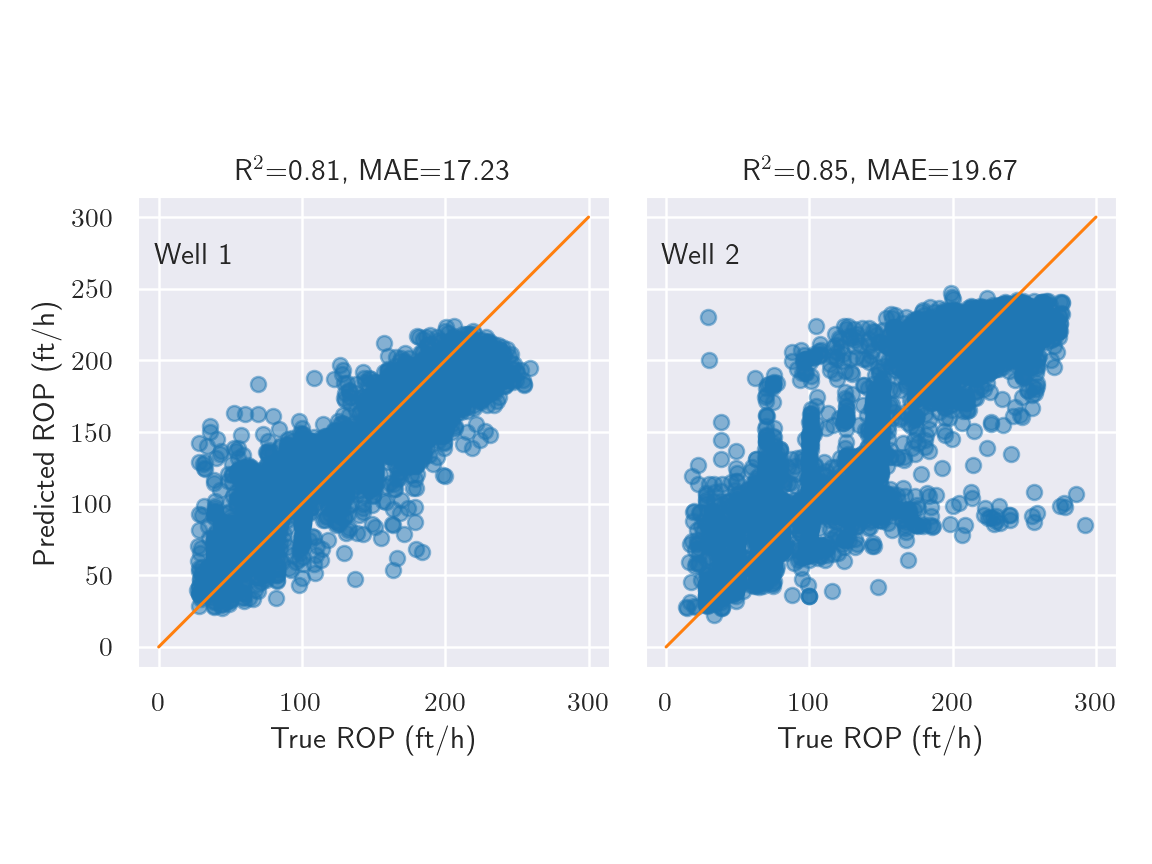

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=120)

ax[0].plot(y1, y_mean1, 'o', alpha=0.5, color='tab:blue')
ax[0].plot([0,300], [0,300], '-', linewidth=1.2, color='tab:orange')

ax[1].plot(y2, y_mean2, 'o', alpha=0.5, color='tab:blue')
ax[1].plot([0,300], [0,300], '-', linewidth=1.2, color='tab:orange')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].set_xlabel('True ROP (ft/h)')
ax[1].set_xlabel('True ROP (ft/h)')
ax[0].set_ylabel('Predicted ROP (ft/h)')

ax[0].set_title(f'R$^{2}$={R2_1:0.2f}, MAE={MAE1:0.2f}')
ax[1].set_title(f'R$^{2}$={R2_2:0.2f}, MAE={MAE2:0.2f}')

ax[0].annotate('Well 1', xy=(0, 300),  xycoords='data',
        xytext=(0.2, 0.9), textcoords='axes fraction', fontsize=12,
        horizontalalignment='right', verticalalignment='top')

ax[1].annotate('Well 2', xy=(0, 300),  xycoords='data',
        xytext=(0.2, 0.9), textcoords='axes fraction', fontsize=12,
        horizontalalignment='right', verticalalignment='top')


plt.tight_layout()
plt.show()

## Plot predictions

In [15]:
alpha=0.9
max_md = w2['Hole Depth'].max()
min_md = 9000

def _plot_rop_depth(depth, rop_true, rop_pred, test=True):
        _, ax = plt.subplots(dpi=120, figsize=(14, 4), nrows=2)

        rop_min  = rop_pred.min(axis=0)
        rop_max = rop_pred.max(axis=0)
        rop_mean = rop_pred.mean(axis=0)
        
        ax[0].plot(depth, rop_true, '-', alpha=0.75, 
                        linewidth=1,  color='tab:blue', label='True ROP')

        ax[0].plot(depth, rop_mean, '-', alpha=0.75, linewidth=1,  
                        color='tab:orange', label=r'$\overline{ROP}$')
        
        ax[0].fill_between(x=depth, y1=rop_min, y2=rop_max, 
                            color='tab:green', alpha=0.4)

        ax[0].set_xlabel('Measured Depth (ft)', alpha=alpha, fontsize=12)
        ax[0].set_ylabel('ROP (ft/h)', alpha=alpha, fontsize=12)

        # ax.set_title(title, alpha=0.75)

        l = ax[0].legend(frameon=False, loc='upper left', fontsize=12, ncol=1)
        for text in l.get_texts():
                text.set_alpha(alpha)

        ax[0].tick_params(labelsize=12)
        
        for text in ax[1].get_xticklabels():
                text.set_alpha(alpha)
                
        for text in ax[1].get_yticklabels():
                text.set_alpha(alpha)

        for t in ax[1].xaxis.get_ticklines():
                t.set_alpha(alpha)

        for t in ax[1].yaxis.get_ticklines():
                t.set_alpha(alpha)
                
        for spine in ['top', 'bottom', 'right', 'left']:
                ax[0].spines[spine].set_alpha(alpha)
                ax[0].spines[spine].set_linewidth(1)
                ax[1].spines[spine].set_alpha(alpha)
                ax[1].spines[spine].set_linewidth(1)

        

        ax[1].plot(depth, rop_true, '-', alpha=0.75, 
                        linewidth=1,  color='tab:blue', label='True ROP')

        ax[1].plot(depth, rop_mean, '-', alpha=0.75, linewidth=1,  
                        color='tab:orange', label=r'$\overline{ROP}$')
        
        ax[1].fill_between(x=depth, y1=rop_min, y2=rop_max, 
                            color='tab:green', alpha=0.4)


        # ax.invert_yaxis()
        if test:
                rect = Rectangle((min_md, 25), max_md-min_md, 300, linewidth=1.2, edgecolor='tab:gray', 
                        facecolor='none', alpha=alpha, linestyle='--')
                ax[0].add_patch(rect)
                ax[1].set_xlim([min_md, max_md])
                
                ax[0].annotate('Test section', xy=(max_md-2500, 300),  xycoords='data',
                        xytext=(0.8, 0.95), textcoords='axes fraction', fontsize=12,
                        horizontalalignment='right', verticalalignment='top')
                
                ax[1].annotate('Test section', xy=(max_md-2500, 300),  xycoords='data',
                        xytext=(0.1, 0.95), textcoords='axes fraction', fontsize=12,
                        horizontalalignment='right', verticalalignment='top')

                ax[0].set_ylim([0,400])
                ax[1].set_ylim([0,400])

        elif not test:
                rect = Rectangle((8500, 25), 3000, 260, linewidth=1.2, edgecolor='tab:gray', 
                        facecolor='none', alpha=alpha, linestyle='--')
                ax[0].add_patch(rect)
                ax[1].set_xlim([8500, 11500])
                ax[0].set_ylim([0,320])
                ax[1].set_ylim([0,320])


        ax[1].set_xlabel('Measured Depth (ft)', alpha=alpha, fontsize=12)
        ax[1].set_ylabel('ROP (ft/h)', alpha=alpha, fontsize=12)
        ax[1].tick_params(labelsize=12)

        
        plt.tight_layout()        
        plt.show()


<IPython.core.display.Javascript object>


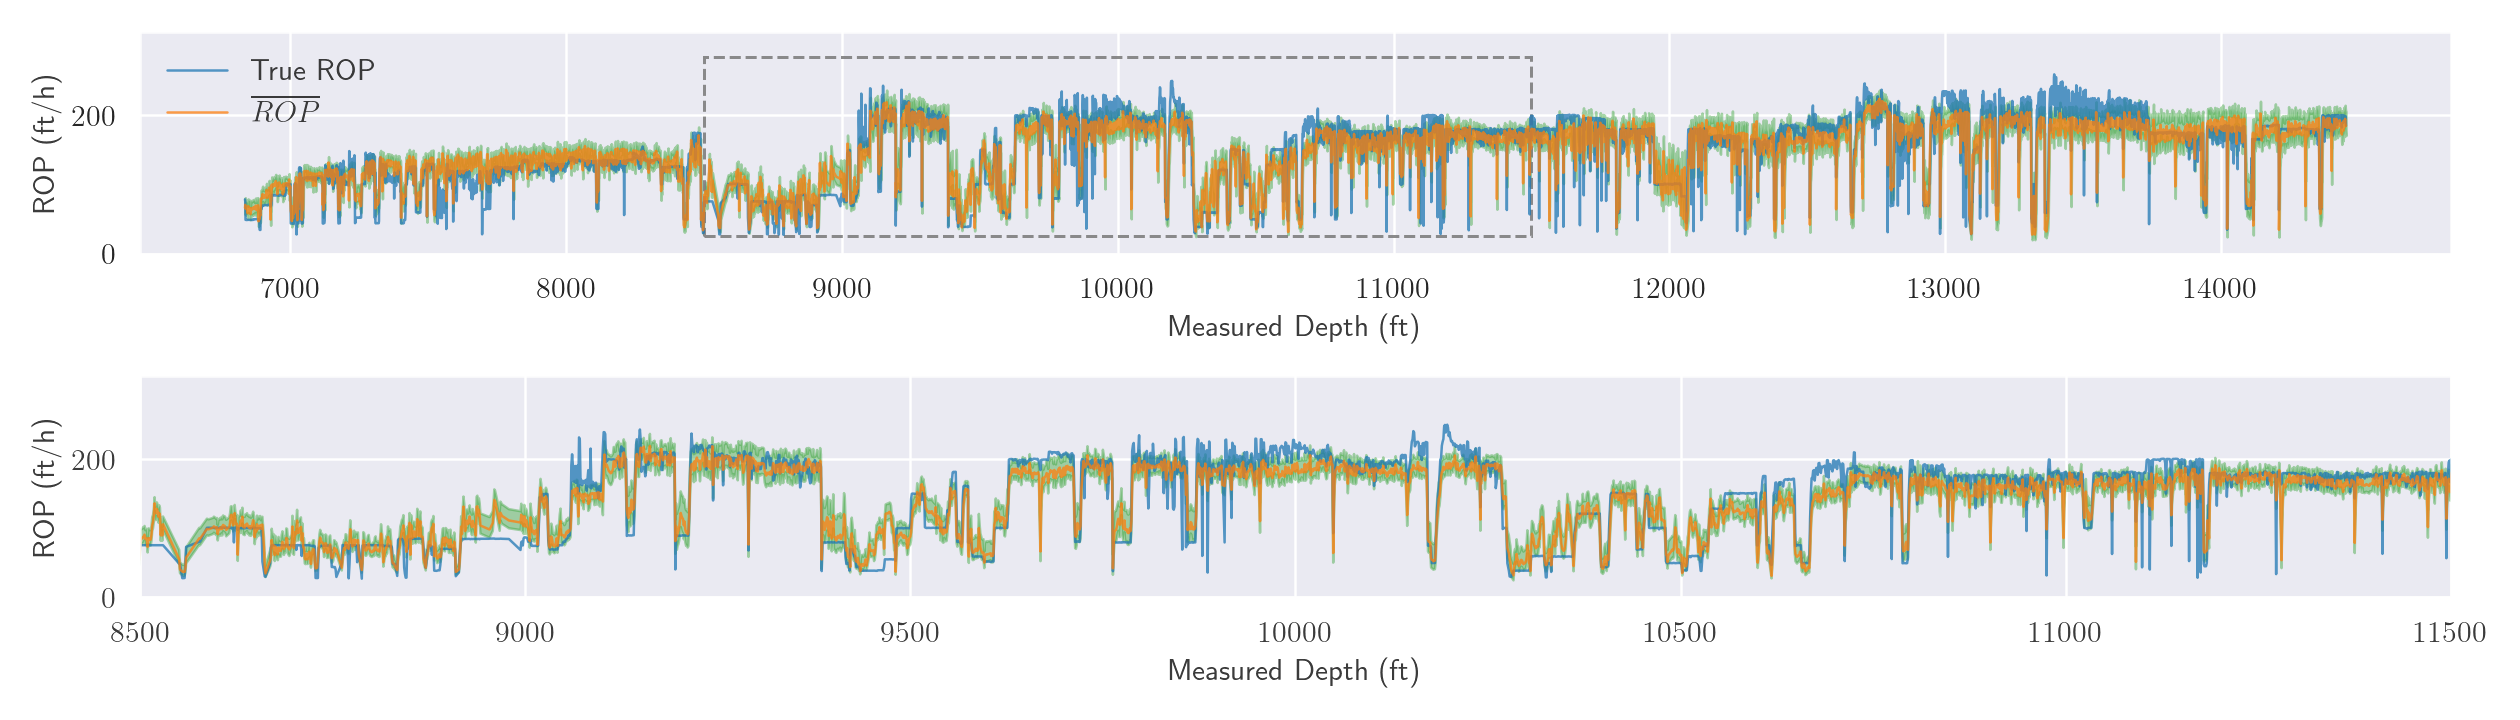

In [16]:
 _plot_rop_depth(depth=w1['Hole Depth'],
                 rop_true = w1['Rate Of Penetration'], 
                 rop_pred = rop_mean_1, 
                 test=False)

<IPython.core.display.Javascript object>


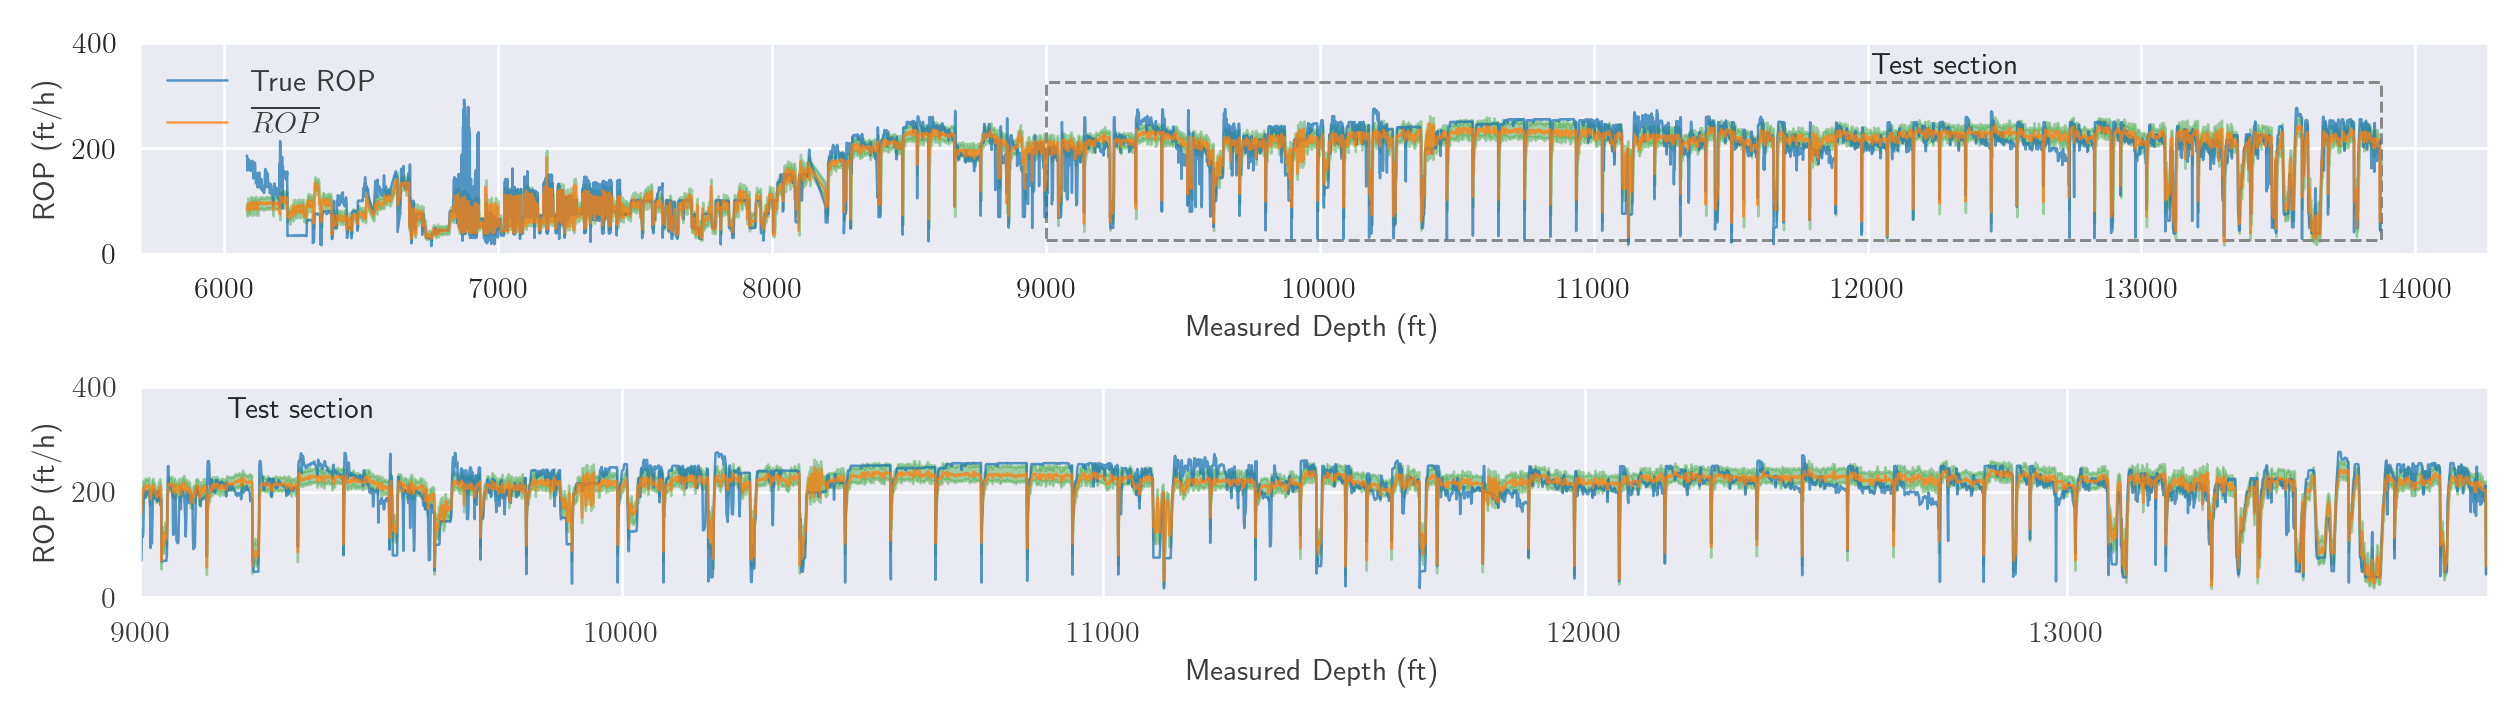

In [17]:
 _plot_rop_depth(depth=w2['Hole Depth'],
                 rop_true = w2['Rate Of Penetration'], 
                 rop_pred = rop_mean_2, 
                 test=True)

## Absolute difference 

In [18]:
def _boxplot(x, ax, label, pos = [1], c1='tab:blue', c2 = 'tab:orange'):
        return ax.boxplot(x, labels=[label], 
                        positions = pos, showfliers=True,
                        patch_artist=True,
                        boxprops=dict(facecolor='w', 
                        color=c1, alpha=1),
                        capprops=dict(color=c1),
                        whiskerprops=dict(color=c1),
                        flierprops=dict(color=c1, markeredgecolor=c1, markersize=1.5),
                        medianprops=dict(color=c2, linewidth=1))


<IPython.core.display.Javascript object>


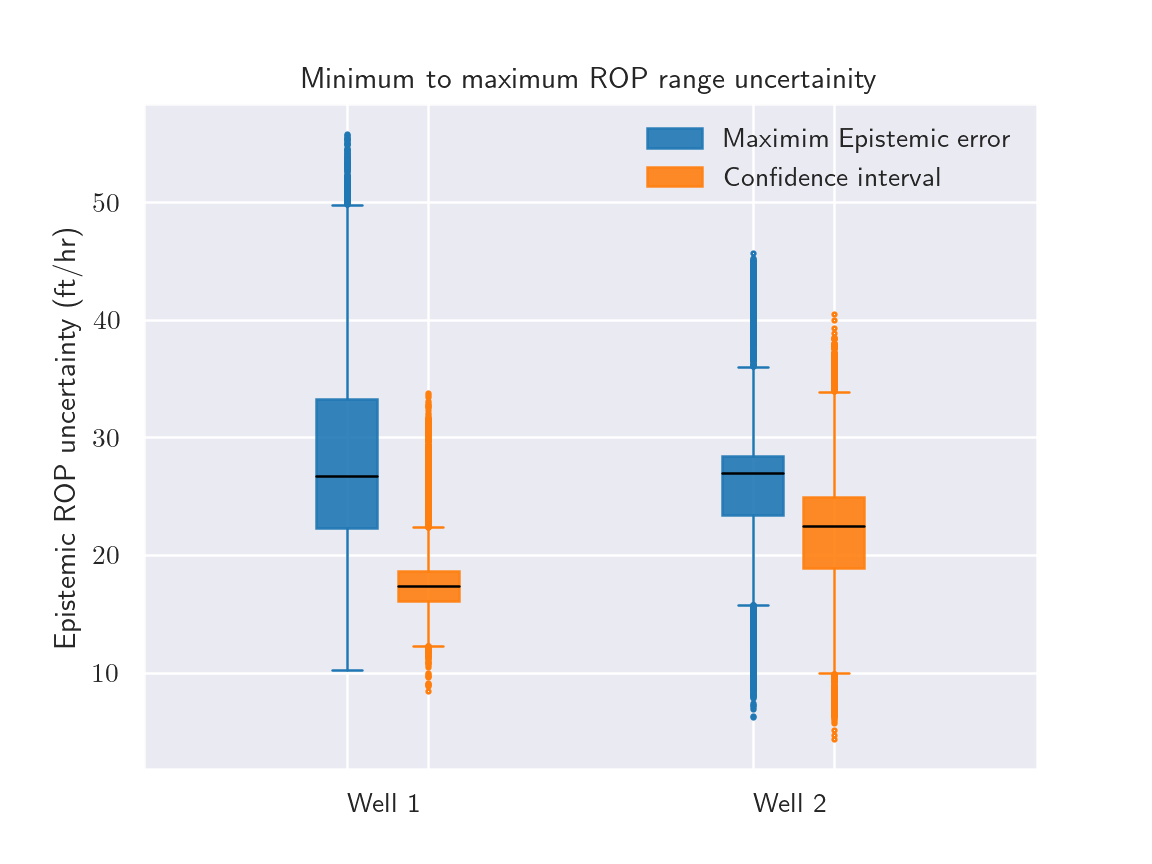

In [19]:
w1_diff = (rop_mean_1.max(axis=0) - rop_mean_1.min(axis=0))
w2_diff = (rop_mean_2.max(axis=0) - rop_mean_2.min(axis=0))

w1_ci = (np.percentile(rop_mean_1, 97.5, axis=0) - np.percentile(rop_mean_1, 2.5, axis=0))
w2_ci = (np.percentile(rop_mean_2, 97.5, axis=0) - np.percentile(rop_mean_2, 2.5, axis=0))


fig, ax = plt.subplots(dpi=120)

B1 = _boxplot(w1_diff, ax, label = 'Well 1', pos=[1], c1='tab:blue', c2 = 'black')
B2 = _boxplot(w1_ci, ax, label = '', pos=[1.2], c1='tab:orange', c2 = 'black')
B3 = _boxplot(w2_diff, ax, label = 'Well 2', pos=[2], c1='tab:blue', c2 = 'black')
B4 = _boxplot(w2_ci, ax, label = '', pos=[2.2], c1='tab:orange', c2 = 'black')

for b1, b2 in zip(B1['boxes'], B2['boxes']):
        # box.set_hatch('////////')
        b1.set_facecolor('tab:blue')
        b2.set_facecolor('tab:orange')
        b1.set_alpha(0.9)
        b2.set_alpha(0.9)
        
for b1, b2 in zip(B3['boxes'], B4['boxes']):
        # box.set_hatch('////////')
        b1.set_facecolor('tab:blue')
        b2.set_facecolor('tab:orange')
        b1.set_alpha(0.9)
        b2.set_alpha(0.9)

        
ax.set_ylabel('Epistemic ROP uncertainty (ft/hr)')
ax.set_title('Minimum to maximum ROP range uncertainity')
for label in ax.get_xticklabels():
        label.set_ha("left")
        label.set_rotation(0)

ax.tick_params(axis='x', which='minor', bottom=False, top = False)
ax.tick_params(axis='x', which='major', bottom=False, top = False)

for spine in ['top', 'bottom', 'right', 'left']:
        ax.spines[spine].set_alpha(alpha)
        ax.spines[spine].set_linewidth(1)
        

ax.legend([B1["boxes"][0], B2["boxes"][0]],
        ['Maximim Epistemic error', 'Confidence interval'], loc='upper right', frameon=False)


plt.show()
